This notebook performs several analysis steps on the unnormalized posteriors computed by `save_posterior_table()`:
* Plots MC errors on $p_\gamma$;
* Normalizes the posteriors and saves the results to tables;
* Computes and saves 95% CI bounds on $\langle \sigma v \rangle$;
* Creates plots of these bounds overlayed on a color mesh of the unnormalized posteriors for DM mass.

$\langle \sigma v \rangle$ grid is too small for:
* `M=0.5, N=1, merger_rate_prior="LF", lambda_prior="LF", sv_prior="U"`
* `M=0.5, N=1, merger_rate_prior="J", lambda_prior="LF", sv_prior="U"`
* `M=10., N=1, merger_rate_prior="LF", lambda_prior="LF", sv_prior="U"`
* `M=10., N=1, merger_rate_prior="J", lambda_prior="LF", sv_prior="U"`

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm_notebook as tqdm
from scipy.integrate import quad, trapz, cumtrapz
from scipy.interpolate import interp1d
from scipy.optimize import root_scalar

from constants import n_u_0, m_mw_dm, h_hubble
from pbhhalosim import PBHHaloSim
from posterior_inference import load_posterior, post_sv_dir
from posterior_inference import save_normalized_posterior_table, save_sv_bounds
from posterior_inference import save_p_gamma_table, load_p_gamma

In [39]:
m_pbh = 10.
n_pbh = 1
# merger_rate_prior = "LF"  # conservative
merger_rate_prior = "J"  # optimistic
lambda_prior = "LF"  # conservative
sv_prior = "U"  # conservative

# Normalize the posteriors
save_normalized_posterior_table(m_pbh, n_pbh, merger_rate_prior, lambda_prior, sv_prior)
# Compute <sigma v> bounds
m_dms, sv_bounds = save_sv_bounds(m_pbh, n_pbh, merger_rate_prior, lambda_prior, sv_prior)
# Load unnormalized and normalized posteriors
svs, _, post_un_vals = load_posterior(m_pbh, n_pbh, merger_rate_prior,
                                      lambda_prior, sv_prior, normalized=False)
svs, _, post_vals = load_posterior(m_pbh, n_pbh, merger_rate_prior,
                                   lambda_prior, sv_prior, normalized=True)

# MC errors in $p_\gamma$

In [40]:
# Load table
svs, m_dms, p_gamma, p_gamma_err = load_p_gamma(m_pbh)
sv_mg, m_dm_mg = np.meshgrid(svs, m_dms)

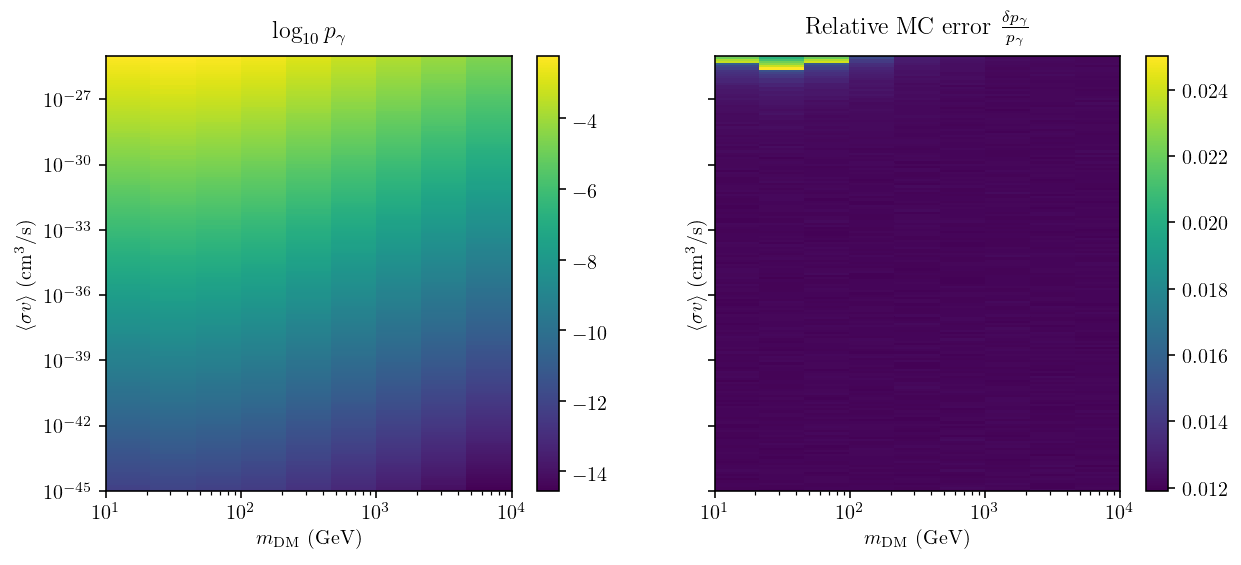

In [41]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))

for ax in axes.flatten():
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
    ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")

ax = axes[0]
ax.set_title(r"$\log_{10} p_\gamma$")
img_vals = ax.pcolormesh(m_dm_mg, sv_mg, np.log10(p_gamma(sv_mg, m_dm_mg)))
plt.colorbar(img_vals, ax=ax)

ax = axes[1]
ax.set_title(r"Relative MC error $\frac{\delta p_\gamma}{p_\gamma}$")
img_rel_errs = ax.pcolormesh(
    m_dm_mg, sv_mg, (p_gamma_err(sv_mg, m_dm_mg) / p_gamma(sv_mg, m_dm_mg)))
plt.colorbar(img_rel_errs, ax=ax)

# PDFs and CDFs

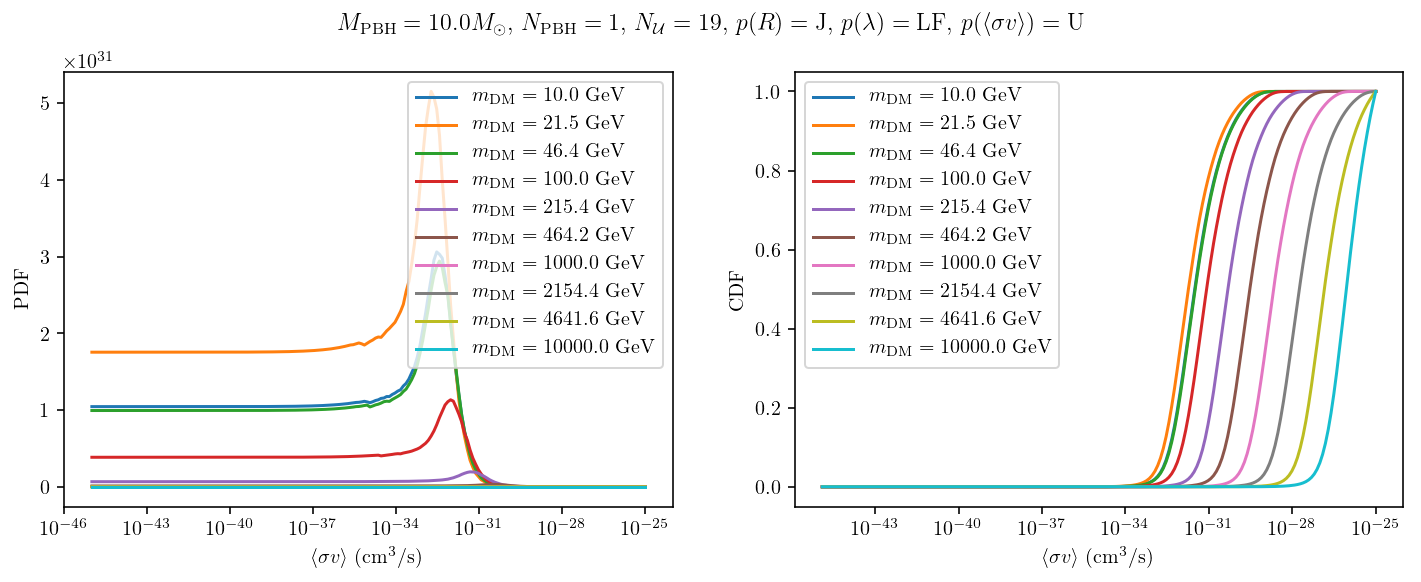

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
for i, m_dm in enumerate(m_dms):
    ax.plot(svs, post_vals[:, i], label=r"$m_{\mathrm{DM}} = %.1f$ GeV" % m_dm)
ax.set_xscale("log")
ax.set_xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_ylabel("PDF")
ax.legend()

ax = axes[1]
for i, m_dm in enumerate(m_dms):
    ax.plot(svs[1:], cumtrapz(post_vals[:, i], svs), label=r"$m_{\mathrm{DM}} = %.1f$ GeV" % m_dm)
ax.set_xscale("log")
ax.set_xlabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_ylabel("CDF")
ax.legend()

fig.suptitle((r"$M_{\mathrm{PBH}}=%.1f M_\odot$, "
              r"$N_{\mathrm{PBH}}=%i$, "
              r"$N_{\mathcal{U}}=%i$, "
              r"$p(R)=\mathrm{%s}$, $p(\lambda)=\mathrm{%s}$, $p(\langle \sigma v \rangle)=\mathrm{%s}$") %
             (m_pbh, n_pbh, n_u_0, merger_rate_prior, lambda_prior, sv_prior))

fig.savefig(
    "figures/sv_bounds/monitoring_M={:.1f}_N={}_prior_rate={}_prior_lambda={}_prior_sv={}.pdf".format(
    m_pbh, n_pbh, merger_rate_prior, lambda_prior, sv_prior))

# Bounds

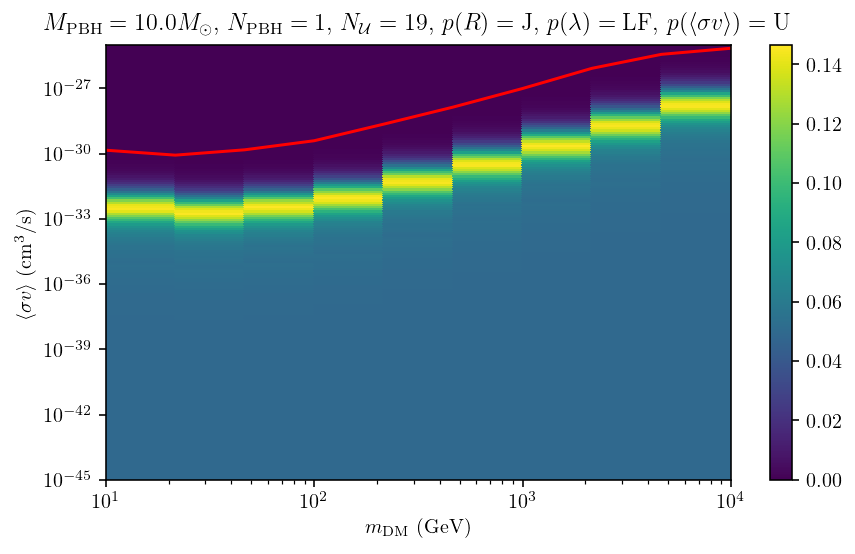

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_title((r"$M_{\mathrm{PBH}}=%.1f M_\odot$, "
              r"$N_{\mathrm{PBH}}=%i$, "
              r"$N_{\mathcal{U}}=%i$, "
              r"$p(R)=\mathrm{%s}$, $p(\lambda)=\mathrm{%s}$, $p(\langle \sigma v \rangle)=\mathrm{%s}$") %
             (m_pbh, n_pbh, n_u_0, merger_rate_prior, lambda_prior, sv_prior))


ax.plot(m_dms, sv_bounds, 'r')
m_dm_mg, sv_mg = np.meshgrid(m_dms, svs)
post_pcmesh = ax.pcolormesh(m_dm_mg, sv_mg, post_un_vals[:-1, :-1], edgecolor="face")
fig.colorbar(post_pcmesh)

fig.savefig(
    "figures/sv_bounds/post_sv_M={:.1f}_N={}_prior_rate={}_prior_lambda={}_prior_sv={}.pdf".format(
    m_pbh, n_pbh, merger_rate_prior, lambda_prior, sv_prior))

# Compare bounds for different $M_{\mathrm{PBH}}$

In [13]:
n_pbh = 1
m_pbhs = np.arange(0.2, 1.1, 0.1)
bounds = {}
for m_pbh in m_pbhs:
    m_dms, cur_bound = np.loadtxt("data/bounds/sv_bounds_M={:.1f}_N={}.csv".format(m_pbh, n_pbh)).T
    bounds[m_pbh] = cur_bound

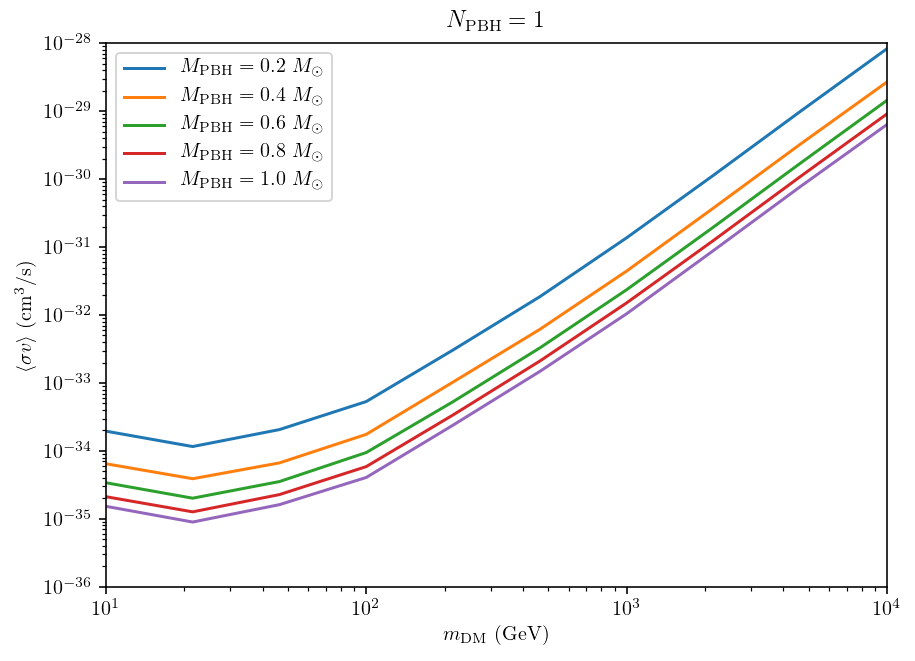

In [28]:
fig, ax = plt.subplots(figsize=(7, 5))

for m_pbh in m_pbhs[::2]:
    ax.plot(m_dms, bounds[m_pbh], label=r"$M_{\mathrm{PBH}} = %.1f~M_\odot$" % m_pbh)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(m_dms[[0, -1]])
ax.set_ylim(1e-36, 1e-28)
ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_title(r"$N_{\mathrm{PBH}}=%i$" % n_pbh)
ax.legend()
fig.savefig("figures/sv_bounds/N={}.pdf".format(n_pbh))

# Compare bounds for different $N_{\mathrm{PBH}}$

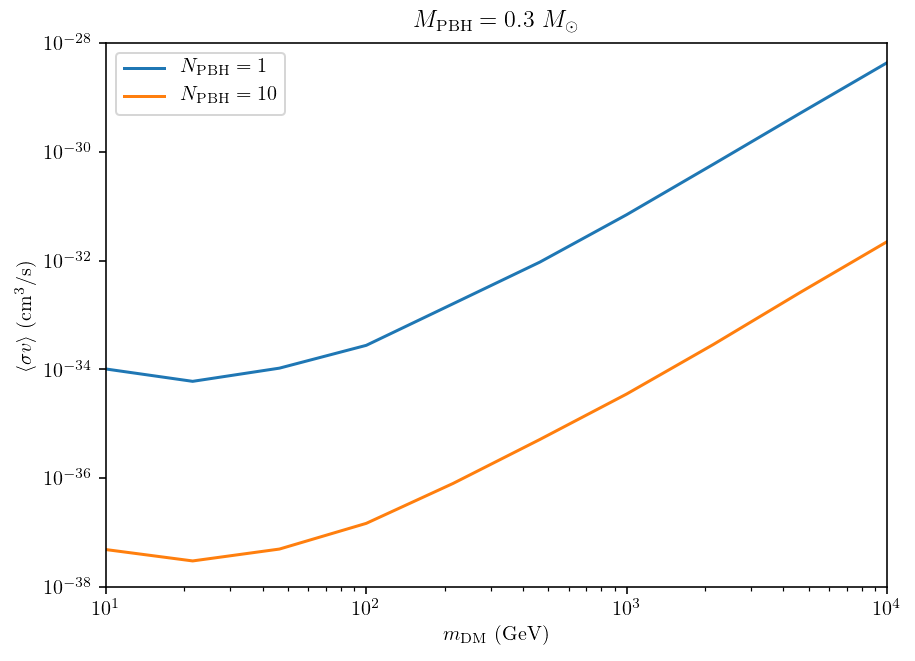

In [29]:
m_pbh = 0.3
m_dms, bound_1 = np.loadtxt("data/bounds/sv_bounds_M={:.1f}_N={}.csv".format(m_pbh, 1)).T
m_dms, bound_10 = np.loadtxt("data/bounds/sv_bounds_M={:.1f}_N={}.csv".format(m_pbh, 10)).T

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(m_dms, bound_1, label=r"$N_{\mathrm{PBH}}=1$")
ax.plot(m_dms, bound_10, label=r"$N_{\mathrm{PBH}}=10$")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(m_dms[[0, -1]])
ax.set_ylim(1e-38, 1e-28)
ax.set_xlabel(r"$m_{\mathrm{DM}}$ (GeV)")
ax.set_ylabel(r"$\langle \sigma v \rangle$ (cm$^3$/s)")
ax.set_title(r"$M_{\mathrm{PBH}} = %.1f~M_\odot$" % m_pbh)
ax.legend()

fig.savefig("figures/sv_bounds/M={:.1f}.pdf".format(m_pbh))

# How close does a PBH need to be from earth to be detectable?

Should make sure it actually appears point-like

In [8]:
sim = PBHHaloSim(mass_dist=0.3, f_pbh=1e-2, m_dm = 20, sv=2e-38, n_samples=1000)
sim.run()
# Max distance at which gamma rays from the PBH would be detectable
d_det_max = np.sqrt(sim._flux_helper(sim.ann_rates[0], sim.flux_fact, 1.) / sim.flux_thresh)

Text(0.5, 1.0, 'UCMH tidal radii')

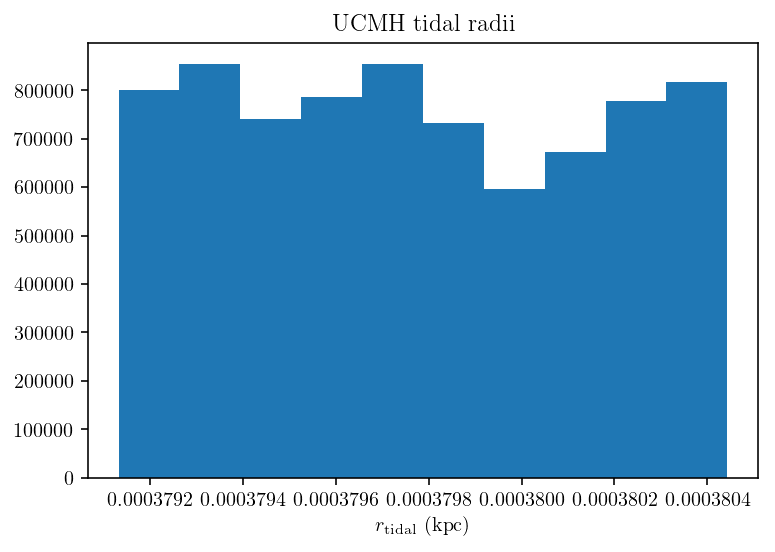

In [19]:
r_tidals = sim.positions_abs[0] * (sim.mass_dist / m_mw_dm)**(1/3)
plt.hist(r_tidals, density=True)

plt.xlabel(r"$r_{\mathrm{tidal}}$ (kpc)")
plt.title("UCMH tidal radii")

Text(0.5, 1.0, 'UCMH distances from Earth')

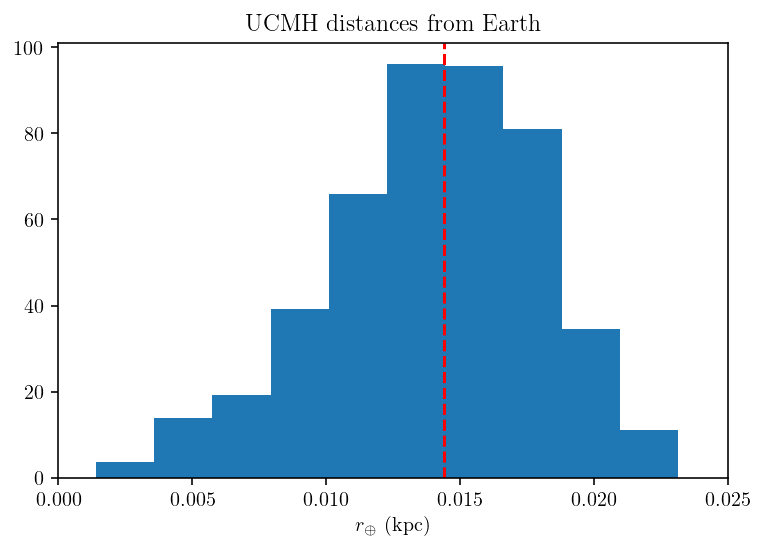

In [22]:
plt.hist(sim.positions[0], density=True)
plt.axvline(d_det_max, color='r', linestyle='--')

plt.xlabel(r"$r_{\oplus}$ (kpc)")
plt.xlim(0, 0.025)
plt.title("UCMH distances from Earth")

The UCMH distances are at least an order of magnitude larger than the tidal radii, so I'd say we're safe.